In [1]:
import numpy as np
import torch
from torch import nn
import torchvision
from torchvision import transforms
import moviepy.editor as mvp
from IPython.display import display

from utils import VideoWriter, imshow, get_coords
from data_loader import MNIST
from models import Siren

In [2]:
data = MNIST(batch_size=1)
coords = get_coords(28).cuda()

loss_fn = nn.MSELoss()
meta_lr = 1e-5
inner_lr = 1e-2
optim_steps = 2

meta_net = Siren(in_features=2, out_features=1, hidden_features=128, hidden_layers=2)
meta_net.cuda()
meta_optimizer = torch.optim.Adam(meta_net.parameters(), lr=meta_lr)

[500 / 5000] loss: 0.2811560032963753
[1000 / 5000] loss: 0.17196182961761952
[1500 / 5000] loss: 0.1332788502648473
[2000 / 5000] loss: 0.11542093925178051
[2500 / 5000] loss: 0.10368995047360659
[3000 / 5000] loss: 0.0942041634581983
[3500 / 5000] loss: 0.08762864299491048
[4000 / 5000] loss: 0.08407424504309893
[4500 / 5000] loss: 0.07770486481115221
[5000 / 5000] loss: 0.07410474193841218
Finished


Target:


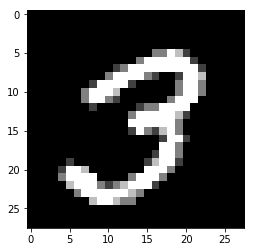

In [3]:
resize = transforms.Resize(256, interpolation=0)
frame_every = 50
vid_target = None
print_every = 500
running_loss = 0
break_at = 5000

with VideoWriter('output/train.mp4') as vid:
    for meta_iter, [images, _] in enumerate(data.train_loader, 0):
        net = meta_net.clone()
        optimizer = torch.optim.SGD(net.parameters(), lr=inner_lr)
        
        target = images[0].reshape(-1, 1).cuda()
        if meta_iter == 0:
            vid_target = target
        if (meta_iter + 1) % frame_every == 0:
            target = vid_target
        
        y = None
        for i in range(optim_steps):
            y = net(coords)
            loss = loss_fn(y, target)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            if i == optim_steps - 1 and (meta_iter + 1) % frame_every != 0:
                running_loss += loss.item()
        
        if (meta_iter + 1) % frame_every == 0:
            init_frame = resize(meta_net(coords).detach().reshape(1, 28, 28))
            optim_frame = resize(y.detach().reshape(1, 28, 28))
            vid.add(torch.cat([init_frame, optim_frame], dim=2).cpu())
        else:
            meta_net.point_grad_to(net)
            meta_optimizer.step()
        
        if (meta_iter + 1) % print_every == 0:
            print(f'[{meta_iter + 1} / {min(break_at, len(data.train_loader))}] loss: {running_loss / print_every}')
            running_loss = 0
        
        if meta_iter + 1 == break_at:
            break

torch.save(meta_net.state_dict(), 'output/meta_net.pt')

print('Finished')
display(mvp.ipython_display('output/train.mp4', loop=True))
print('Target:')
imshow(vid_target.detach().reshape(1, 28, 28).cpu())